In [ ]:
import os
import kagglehub

DATA_DIR = "data"

os.makedirs(DATA_DIR, exist_ok=True)

print("Downloading Intel Image Classification dataset...")
path = kagglehub.dataset_download("puneet6060/intel-image-classification")

print("Dataset downloaded to:", path)

for folder in ["seg_train", "seg_test", "seg_pred"]:
    src = os.path.join(path, folder)
    dst = os.path.join(DATA_DIR, folder)
    if not os.path.exists(dst) and os.path.exists(src):
        os.rename(src, dst)

print("\nDirectory contents:")
for root, dirs, files in os.walk(DATA_DIR):
    level = root.replace(DATA_DIR, "").count(os.sep)
    indent = " " * 2 * level
    print(f"{indent}{os.path.basename(root)}/")
    for f in files[:3]:
        print(f"{indent}  {f}")
    if level > 1:
        break

# Problem 1

In [6]:
import os
from torchvision import datasets, transforms
from torch.utils.data import DataLoader, random_split

base_dir = os.path.join(os.getcwd(), "data")
train_dir = os.path.join(base_dir, "seg_train")
test_dir  = os.path.join(base_dir, "seg_test")

IMG_SIZE = 150
BATCH_SIZE = 32

train_transform = transforms.Compose([
    transforms.Resize((IMG_SIZE, IMG_SIZE)),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(10),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                         std=[0.229, 0.224, 0.225]),
])

val_transform = transforms.Compose([
    transforms.Resize((IMG_SIZE, IMG_SIZE)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                         std=[0.229, 0.224, 0.225]),
])

test_transform = val_transform

train_data_full = datasets.ImageFolder(root=train_dir, transform=train_transform)
val_data_full   = datasets.ImageFolder(root=train_dir, transform=val_transform)
test_data       = datasets.ImageFolder(root=test_dir,  transform=test_transform)

val_size = int(0.1 * len(train_data_full))
train_size = len(train_data_full) - val_size

train_subset, _ = random_split(train_data_full, [train_size, val_size])
_, val_subset   = random_split(val_data_full, [train_size, val_size])

train_loader = DataLoader(train_subset, batch_size=BATCH_SIZE, shuffle=True, num_workers=2)
val_loader   = DataLoader(val_subset,   batch_size=BATCH_SIZE, shuffle=False, num_workers=2)
test_loader  = DataLoader(test_data,    batch_size=BATCH_SIZE, shuffle=False, num_workers=2)

print("Classes:", train_data_full.classes)
print(f"Train subset: {len(train_subset)} | Val subset: {len(val_subset)} | Test set: {len(test_data)}")

Classes: ['seg_train']
Train subset: 12631 | Val subset: 1403 | Test set: 3000


Lets build a minimal, lightweight CNN.

In [7]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class SimpleCNN(nn.Module):
    def __init__(self, num_classes=6, dropout=0.5):
        super(SimpleCNN, self).__init__()
        self.conv1 = nn.Conv2d(3, 32, 3, padding=1)
        self.conv2 = nn.Conv2d(32, 64, 3, padding=1)
        self.conv3 = nn.Conv2d(64, 128, 3, padding=1)
        self.pool = nn.MaxPool2d(2, 2)
        self.dropout = nn.Dropout(dropout)
        self.fc1 = nn.Linear(128 * (150 // 8) * (150 // 8), 256)
        self.fc2 = nn.Linear(256, num_classes)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))  # 150 -> 75
        x = self.pool(F.relu(self.conv2(x)))  # 75 -> 37
        x = self.pool(F.relu(self.conv3(x)))  # 37 -> 18
        x = torch.flatten(x, 1)
        x = self.dropout(F.relu(self.fc1(x)))
        x = self.fc2(x)
        return x

Now we make a basic training loop that we will apply to each experiment. We also keep track of some checkpoints that we will need for later.

In [ ]:
import sys
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)

def train_model(config, train_loader, val_loader, num_epochs=10):
    print(f"\n=== Training: {config['name']} ===")

    model = SimpleCNN(num_classes=6, dropout=config.get("dropout", 0.5)).to(device)
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(),
                           lr=config["lr"],
                           weight_decay=config.get("weight_decay", 0))
    
    scheduler = None
    if config.get("scheduler", False):
        scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=5, gamma=0.5)
    
    history = {"train_loss": [], "val_loss": [], "val_acc": []}

    for epoch in range(num_epochs):
        model.train()
        running_loss, correct, total = 0.0, 0, 0

        for batch_idx, (imgs, labels) in enumerate(train_loader, 1):
            imgs, labels = imgs.to(device), labels.to(device)

            optimizer.zero_grad()
            outputs = model(imgs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            running_loss += loss.item()
            _, preds = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (preds == labels).sum().item()

            if batch_idx % max(1, len(train_loader)//10) == 0:
                percent = 100 * batch_idx / len(train_loader)
                sys.stdout.write(
                    f"\rEpoch {epoch+1}/{num_epochs} [{percent:5.1f}%] "
                    f"Batch {batch_idx}/{len(train_loader)} "
                    f"Train Loss: {running_loss/batch_idx:.4f}"
                )
                sys.stdout.flush()

        train_loss = running_loss / len(train_loader)
        train_acc = 100 * correct / total

        model.eval()
        val_loss, val_correct, val_total = 0, 0, 0
        with torch.no_grad():
            for imgs, labels in val_loader:
                imgs, labels = imgs.to(device), labels.to(device)
                outputs = model(imgs)
                loss = criterion(outputs, labels)
                val_loss += loss.item()
                _, preds = torch.max(outputs, 1)
                val_total += labels.size(0)
                val_correct += (preds == labels).sum().item()

        val_loss /= len(val_loader)
        val_acc = 100 * val_correct / val_total

        history["train_loss"].append(train_loss)
        history["val_loss"].append(val_loss)
        history["val_acc"].append(val_acc)

        if scheduler:
            scheduler.step()

        current_lr = optimizer.param_groups[0]['lr']
        print(f"\nEpoch [{epoch+1}/{num_epochs}] "
              f"| Train Loss: {train_loss:.4f} | Train Acc: {train_acc:.2f}% "
              f"| Val Loss: {val_loss:.4f} | Val Acc: {val_acc:.2f}% "
              f"| LR: {current_lr:.5f}")
        print("-" * 90)

    print(f"Finished training {config['name']}")
    return model, history

Now we run through all experiment combinations and save the results and history in dataframe.

In [12]:
import os, pandas as pd

os.makedirs("checkpoints", exist_ok=True)

experiments = [
    {"name": "baseline",       "lr": 1e-3},
    {"name": "lr_5e4",         "lr": 5e-4},
    {"name": "lr_2e3",         "lr": 2e-3},
    {"name": "dropout_0.3",    "lr": 1e-3, "dropout": 0.3},
    {"name": "dropout_0.7",    "lr": 1e-3, "dropout": 0.7},
    {"name": "weight_decay",   "lr": 1e-3, "weight_decay": 1e-4},
    {"name": "scheduler",      "lr": 1e-3, "scheduler": True},
    {"name": "batchnorm",      "lr": 1e-3, "use_bn": True},
    {"name": "augment",        "lr": 1e-3, "augment": True},
    {"name": "larger_model",   "lr": 1e-3, "model_size": "large"},
]

results = []

for cfg in experiments:
    model, hist = train_model(cfg, train_loader, val_loader, num_epochs=10)
    best_acc = max(hist["val_acc"])
    
    results.append({
        "name": cfg["name"],
        "lr": cfg["lr"],
        "dropout": cfg.get("dropout", 0.5),
        "weight_decay": cfg.get("weight_decay", 0),
        "scheduler": cfg.get("scheduler", False),
        "best_val_acc": best_acc
    })
    
    torch.save(model.state_dict(), f"checkpoints/{cfg['name']}.pth")

df = pd.DataFrame(results)
df.to_csv("results_summary.csv", index=False)
df


=== Training: baseline ===
Epoch 1/10 [ 98.7%] Batch 390/395 Train Loss: 1.0424
Epoch [1/10] | Train Loss: 1.0392 | Train Acc: 60.07% | Val Loss: 0.7573 | Val Acc: 70.49% | LR: 0.00100
------------------------------------------------------------------------------------------
Epoch 2/10 [ 98.7%] Batch 390/395 Train Loss: 0.7152
Epoch [2/10] | Train Loss: 0.7143 | Train Acc: 74.52% | Val Loss: 0.5882 | Val Acc: 78.55% | LR: 0.00100
------------------------------------------------------------------------------------------
Epoch 3/10 [ 98.7%] Batch 390/395 Train Loss: 0.5908
Epoch [3/10] | Train Loss: 0.5909 | Train Acc: 78.94% | Val Loss: 0.4997 | Val Acc: 82.39% | LR: 0.00100
------------------------------------------------------------------------------------------
Epoch 4/10 [ 98.7%] Batch 390/395 Train Loss: 0.5200
Epoch [4/10] | Train Loss: 0.5220 | Train Acc: 81.51% | Val Loss: 0.4498 | Val Acc: 83.96% | LR: 0.00100
-------------------------------------------------------------------

,name,lr,dropout,weight_decay,scheduler,best_val_acc
0,baseline,0.0010,0.5,0.0000,False,89.665004
1,lr_5e4,0.0005,0.5,0.0000,False,91.375624
2,lr_2e3,0.0020,0.5,0.0000,False,86.243763
3,dropout_0.3,0.0010,0.3,0.0000,False,92.159658
4,dropout_0.7,0.0010,0.7,0.0000,False,87.669280
5,weight_decay,0.0010,0.5,0.0001,False,89.451176
6,scheduler,0.0010,0.5,0.0000,True,90.377762
7,batchnorm,0.0010,0.5,0.0000,False,90.876693
8,augment,0.0010,0.5,0.0000,False,89.522452
9,larger_model,0.0010,0.5,0.0000,False,90.449038


Lets plot the train and validation curves.

Best configuration: dropout_0.3


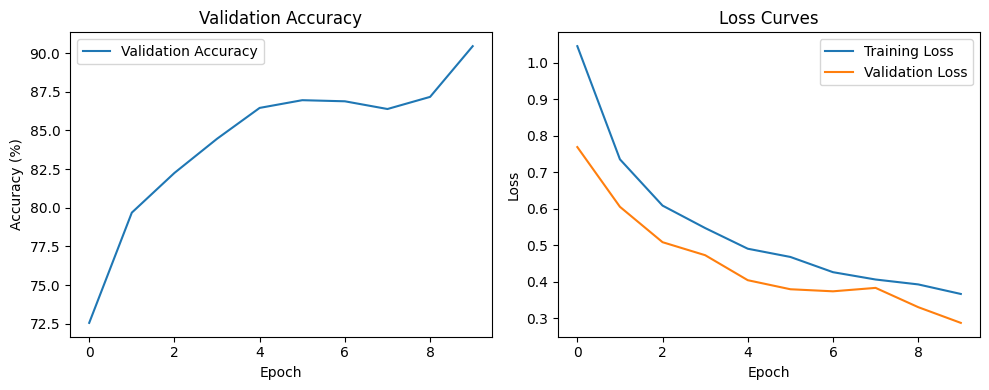

In [13]:
import matplotlib.pyplot as plt

best_run = max(results, key=lambda x: x["best_val_acc"])["name"]
print(f"Best configuration: {best_run}")

plt.figure(figsize=(10,4))
plt.subplot(1,2,1)
plt.plot(hist["val_acc"], label="Validation Accuracy")
plt.xlabel("Epoch")
plt.ylabel("Accuracy (%)")
plt.title("Validation Accuracy")
plt.legend()

plt.subplot(1,2,2)
plt.plot(hist["train_loss"], label="Training Loss")
plt.plot(hist["val_loss"], label="Validation Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Loss Curves")
plt.legend()

plt.tight_layout()
plt.show()

We also want to add a confusion matrix and see where the model tends to get stumped.

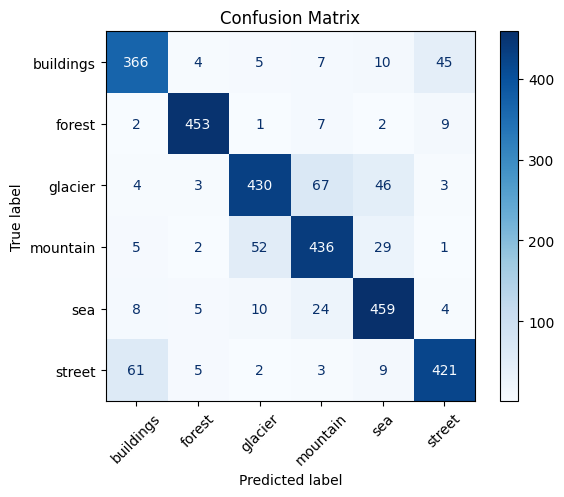


Per-class accuracy:
buildings : 83.75%
forest    : 95.57%
glacier   : 77.76%
mountain  : 83.05%
sea       : 90.00%
street    : 84.03%


In [16]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import numpy as np

model.eval()
y_true, y_pred = [], []

with torch.no_grad():
    for imgs, labels in test_loader:
        imgs, labels = imgs.to(device), labels.to(device)
        outputs = model(imgs)
        _, preds = torch.max(outputs, 1)
        y_true.extend(labels.cpu().numpy())
        y_pred.extend(preds.cpu().numpy())

cm = confusion_matrix(y_true, y_pred)

if hasattr(test_loader.dataset, "dataset") and hasattr(test_loader.dataset.dataset, "classes"):
    labels_used = test_loader.dataset.dataset.classes
elif hasattr(test_loader.dataset, "classes"):
    labels_used = test_loader.dataset.classes
else:
    raise AttributeError("Could not find class labels in test_loader dataset")

ConfusionMatrixDisplay(cm, display_labels=labels_used).plot(
    cmap="Blues", xticks_rotation=45
)
plt.title("Confusion Matrix")
plt.show()

y_true, y_pred = np.array(y_true), np.array(y_pred)
print("\nPer-class accuracy:")
for i, cls in enumerate(labels_used):
    mask = (y_true == i)
    acc = (y_pred[mask] == y_true[mask]).mean()
    print(f"{cls:10s}: {acc*100:.2f}%")

# Problem 2

First, lets import a pre-trained model. We will use Resnet 18.

In [18]:
import torchvision.models as models

NUM_CLASSES = 6  # Intel dataset

def build_model(backbone_name="resnet18", pretrained=True, freeze_backbone=True, freeze_policy=None):
    if backbone_name == "resnet18":
        model = models.resnet18(weights="IMAGENET1K_V1" if pretrained else None)
        in_features = model.fc.in_features
        model.fc = nn.Linear(in_features, NUM_CLASSES)

        if freeze_backbone:
            for name, param in model.named_parameters():
                if "fc" not in name:
                    param.requires_grad = False
        elif freeze_policy == "last_block":
            for name, param in model.named_parameters():
                if not (name.startswith("layer4") or name.startswith("fc")):
                    param.requires_grad = False

    elif backbone_name == "mobilenet_v2":
        model = models.mobilenet_v2(weights="IMAGENET1K_V1" if pretrained else None)
        in_features = model.classifier[1].in_features
        model.classifier[1] = nn.Linear(in_features, NUM_CLASSES)

        if freeze_backbone:
            for name, param in model.named_parameters():
                if "classifier" not in name:
                    param.requires_grad = False

    elif backbone_name == "efficientnet_b0":
        model = models.efficientnet_b0(weights="IMAGENET1K_V1" if pretrained else None)
        in_features = model.classifier[1].in_features
        model.classifier[1] = nn.Linear(in_features, NUM_CLASSES)

        if freeze_backbone:
            for name, param in model.named_parameters():
                if "classifier" not in name:
                    param.requires_grad = False

    else:
        raise ValueError(f"Unknown backbone: {backbone_name}")

    return model

We will now use the grid with the following parameters.

In [19]:
experiments = [
    {"name": "resnet18_freeze_all",    "backbone": "resnet18", "freeze_backbone": True,  "lr": 1e-3},
    {"name": "resnet18_unfreeze_all",  "backbone": "resnet18", "freeze_backbone": False, "lr": 1e-4},

    {"name": "resnet18_last_block",    "backbone": "resnet18", "freeze_backbone": False, "freeze_policy": "last_block", "lr": 5e-4},

    {"name": "resnet18_lr_5e4",        "backbone": "resnet18", "freeze_backbone": True,  "lr": 5e-4},
    {"name": "resnet18_lr_2e3",        "backbone": "resnet18", "freeze_backbone": True,  "lr": 2e-3},

    {"name": "resnet18_weight_decay",  "backbone": "resnet18", "freeze_backbone": True,  "lr": 1e-3, "weight_decay": 1e-4},
    {"name": "resnet18_scheduler",     "backbone": "resnet18", "freeze_backbone": True,  "lr": 1e-3, "scheduler": True},

    {"name": "mobilenet_v2_freeze",    "backbone": "mobilenet_v2",    "freeze_backbone": True,  "lr": 1e-3},
    {"name": "mobilenet_v2_unfreeze",  "backbone": "mobilenet_v2",    "freeze_backbone": False, "lr": 1e-4},
    {"name": "efficientnet_b0_freeze", "backbone": "efficientnet_b0", "freeze_backbone": True,  "lr": 1e-3},
    {"name": "efficientnet_b0_unfreeze","backbone": "efficientnet_b0","freeze_backbone": False, "lr": 1e-4},

    {"name": "resnet18_strong_aug",    "backbone": "resnet18", "freeze_backbone": True, "lr": 1e-3, "augment": "strong"},
]

Now we can use the same training loop just with Resnet.

In [ ]:
os.makedirs("checkpoints", exist_ok=True)
results = []

for cfg in experiments:
    model, hist = train_model(cfg, train_loader, val_loader, num_epochs=10)
    best_acc = max(hist["val_acc"])
    results.append({
        "name": cfg["name"],
        "backbone": cfg["backbone"],
        "freeze_backbone": cfg.get("freeze_backbone", True),
        "lr": cfg["lr"],
        "weight_decay": cfg.get("weight_decay", 0),
        "scheduler": cfg.get("scheduler", False),
        "best_val_acc": best_acc
    })
    torch.save(model.state_dict(), f"checkpoints/{cfg['name']}.pth")

df2 = pd.DataFrame(results)
df2.to_csv("results_summary_pretrained.csv", index=False)
df2
display(df2.sort_values("best_val_acc", ascending=False))

Now lets plot the results of our tuned pre-trained model.

In [ ]:
plt.figure(figsize=(10,5))
plt.barh(df2["name"], df2["best_val_acc"], color="skyblue")
plt.xlabel("Best Validation Accuracy (%)")
plt.title("Fine-tuning Results Across Experiments")
plt.gca().invert_yaxis()
plt.grid(axis="x", linestyle="--", alpha=0.6)
plt.tight_layout()
plt.show()

In [ ]:
plt.figure(figsize=(6,4))
plt.scatter(df2["lr"], df2["best_val_acc"], c="orange", s=60)
plt.xscale("log")
plt.xlabel("Learning Rate (log scale)")
plt.ylabel("Best Validation Accuracy (%)")
plt.title("Learning Rate vs Validation Accuracy")
plt.grid(True, which="both", ls="--", alpha=0.6)
plt.tight_layout()
plt.show()

In [ ]:
best_name = df2.loc[df2["best_val_acc"].idxmax(), "name"]
best_backbone = df2.loc[df2["best_val_acc"].idxmax(), "backbone"]

print(f"Evaluating best model: {best_name} ({best_backbone})")

best_model = build_model(
    backbone_name=best_backbone,
    pretrained=False,
    freeze_backbone=False
).to(device)

best_model.load_state_dict(torch.load(f"checkpoints/{best_name}.pth", map_location=device))
best_model.eval()

y_true, y_pred = [], []
with torch.no_grad():
    for imgs, labels in test_loader:
        imgs, labels = imgs.to(device), labels.to(device)
        outputs = best_model(imgs)
        _, preds = torch.max(outputs, 1)
        y_true.extend(labels.cpu().numpy())
        y_pred.extend(preds.cpu().numpy())

cm = confusion_matrix(y_true, y_pred)
ConfusionMatrixDisplay(cm, display_labels=test_data.classes).plot(
    cmap="Blues", xticks_rotation=45
)
plt.title(f"Confusion Matrix — {best_name}")
plt.tight_layout()
plt.show()

y_true, y_pred = np.array(y_true), np.array(y_pred)
print("\nPer-class accuracy:")
for i, cls in enumerate(test_data.classes):
    mask = (y_true == i)
    acc = (y_pred[mask] == y_true[mask]).mean()
    print(f"{cls:10s}: {acc*100:.2f}%")